# Clustering solutions using NMF #

In [12]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np
from collections import Counter
from tqdm import tqdm
import random

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Learning
from sklearn.decomposition import NMF

# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import defaultdict

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import matplotlib.cm as cm
import pandas as pd

%matplotlib inline

### Connecting to database

In [13]:
db = PythonProblems('python.sqlite')

In [14]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
docs_id = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, row in enumerate(cursor.fetchall()):
    file = io.StringIO(row[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))
    docs_id.append(row[0])

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


### Preprocessing solutions into bag of words ###

In [15]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
#vectorizer = CountVectorizer(analyzer = "word",   \
vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.05
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
#train_data_features = train_data_features.toarray()
train_data_features.shape

(758, 28)

# Cálculo do NMF #

### Cálculo dos modelos e da métrica *perplexity* ###

In [16]:
num_topics = list(range(2, min(train_data_features.shape[1], 100)))

In [17]:
output_notebook()

hover = HoverTool(tooltips=[
    ("Model", "$x{0}"),
    ("Reconstruction Error", "@reconstruction"),
    ("Silhouette", "@silhouette")
])


models = {}
x = []
reconstruction = []
silhouette = []

for k in tqdm(num_topics):
    # Build a NMF Model
    model = NMF(n_components=k, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
    document_topic = model.fit_transform(train_data_features)
    silhouette_avg = silhouette_score(train_data_features, np.argmax(document_topic, axis=1))
    models[k] = {
        'model': model,
        'topic_word': model.components_,
        'document_topic': document_topic,
        'reconstruction': model.reconstruction_err_,
        'silhouette': silhouette_avg
    }

    x.append(k)
    reconstruction.append(models[k]["reconstruction"])
    silhouette.append(models[k]["silhouette"])

source = {'x': x, 'reconstruction': reconstruction, 'silhouette': silhouette}

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Reconstruction Error")
plot = figure(**opts)
plot.add_tools(hover)

# Plot reconstruction
l = plot.line(x='x', y='reconstruction', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x', y='reconstruction', color="#2222aa", fill_color="white", size=8, source=source)

# Plot Silhouette
plot.extra_y_ranges = {"silhouette": Range1d(start=0, end=0.5)}
plot.add_layout(LinearAxis(y_range_name="silhouette"), 'right')
l2 = plot.line(x='x', y='silhouette', color="red", line_width=2, source=source, y_range_name='silhouette')
c2 = plot.circle(x='x', y='silhouette', color="red", fill_color="white", size=8, source=source, y_range_name='silhouette')

h = show(plot, notebook_handle=True)

Loading BokehJS ...

100%|██████████| 26/26 [00:01<00:00, 13.82it/s]


### Verificando em * random sample solutions* ###

In [34]:
# Escolhido tópico k
k = 8
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

## Verificando distribuição de documentos por tópico e palavras por tópico

In [35]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=1)
    matrix_norm = matrix / row_sums[:, np.newaxis]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [36]:
docs_names = docs_id
topics = ["Topic %d" %d for d in range(1, document_topic.shape[1]+1)]
words = vectorizer.get_feature_names()

In [37]:
document_topic_norm = normalize_per_row(document_topic)
word_topic = topic_word.T
word_topic_norm = normalize_per_row(word_topic)

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
document_topic_df = pd.DataFrame(document_topic_norm, index=docs_names, columns=topics)
document_topic_df = sort_distribution(document_topic_df, topics, MIN_PROB=0.3)

word_topic_df = pd.DataFrame(word_topic_norm, index=words, columns=topics)
word_topic_df = sort_distribution(word_topic_df, topics, MIN_PROB=0.3)

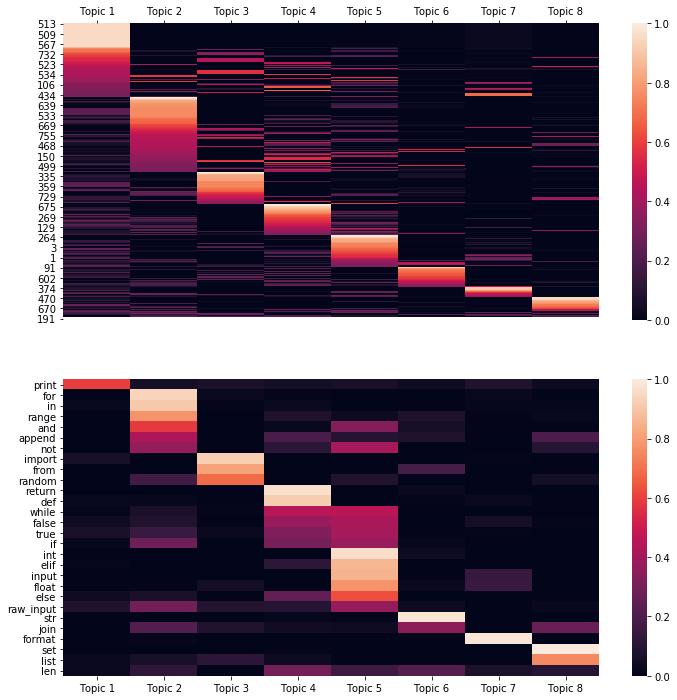

In [39]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12,12))


sns.heatmap(document_topic_df, ax=ax1)
ax1.xaxis.tick_top()
sns.heatmap(word_topic_df, ax=ax2)

plt.show()

### Compare topic distribution with manually labeled categories from the database

In [40]:
sql = "SELECT solution.id, problem.category from solution, problem where solution.problem_id = problem.id"
cursor = db.conn.cursor()
cursor.execute(sql)

rows = cursor.fetchall()
doc_id, doc_category = zip(*rows)

In [45]:
topics_dist = {}

for i in topics:
    df = document_topic_df[document_topic_df[i] > 0.5]
    topics_dist[i] = defaultdict(int)
    for doc in df.index.tolist():
        category = doc_category[doc_id.index(doc)]
        topics_dist[i][category] += 1
        

In [46]:
topics_df = pd.DataFrame.from_dict(topics_dist)

In [47]:
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
string,23.0,18.0,5.0,13.0,NaN,11.0,11.0,9.0
NaN,54.0,49.0,52.0,39.0,49.0,23.0,7.0,8.0
dict,6.0,15.0,6.0,2.0,NaN,NaN,NaN,1.0
list,14.0,6.0,NaN,NaN,1.0,1.0,1.0,14.0
math,5.0,4.0,15.0,6.0,14.0,3.0,4.0,1.0
function,1.0,1.0,NaN,15.0,NaN,NaN,NaN,1.0
file,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
conditional,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN
loop,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN


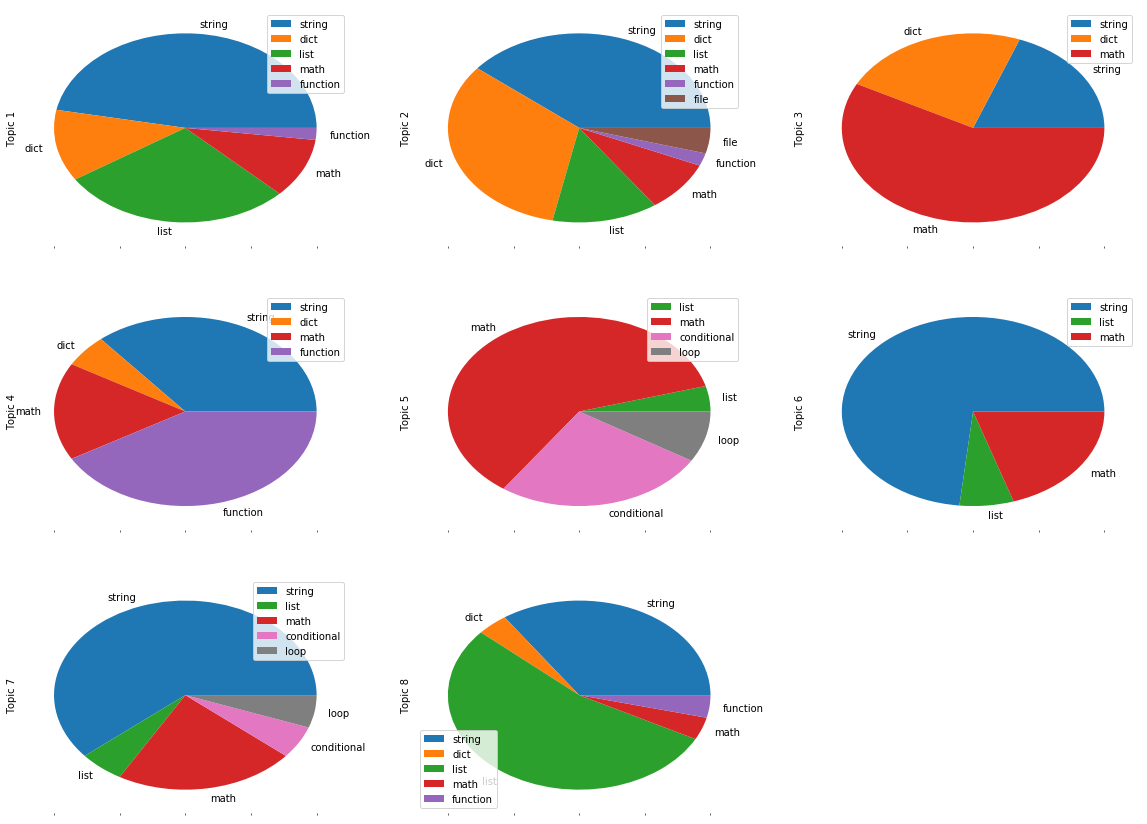

In [48]:
topic_df_nan = topics_df.drop([None])
topic_df_nan.plot.pie(figsize=(20,20), subplots=True, layout=(4, 3))
plt.show()

In [30]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [31]:
print("\nTopics in NMF model:")
feature_names = vectorizer.get_feature_names()
print_top_words(topic_word, feature_names, 10)


Topics in NMF model:
Topic #1: print import def input in else raw_input for true if
Topic #2: in for range if append print and join not raw_input
Topic #3: import from print for raw_input join list true in float
Topic #4: def return print if len while range append false in
Topic #5: int input print raw_input elif range join else append while
Topic #6: str join len from print range return append if int
Topic #7: format print input len def false for true import in
Topic #8: set join print len not list in return raw_input for
Topic #9: random import range and while if join print len in
Topic #10: if else elif true while and false not len print
Topic #11: float input print format if else elif str from len
Topic #12: list append print range def while set from input true



### Cálculo da Silhueta ###

In [32]:
import matplotlib.cm as cm

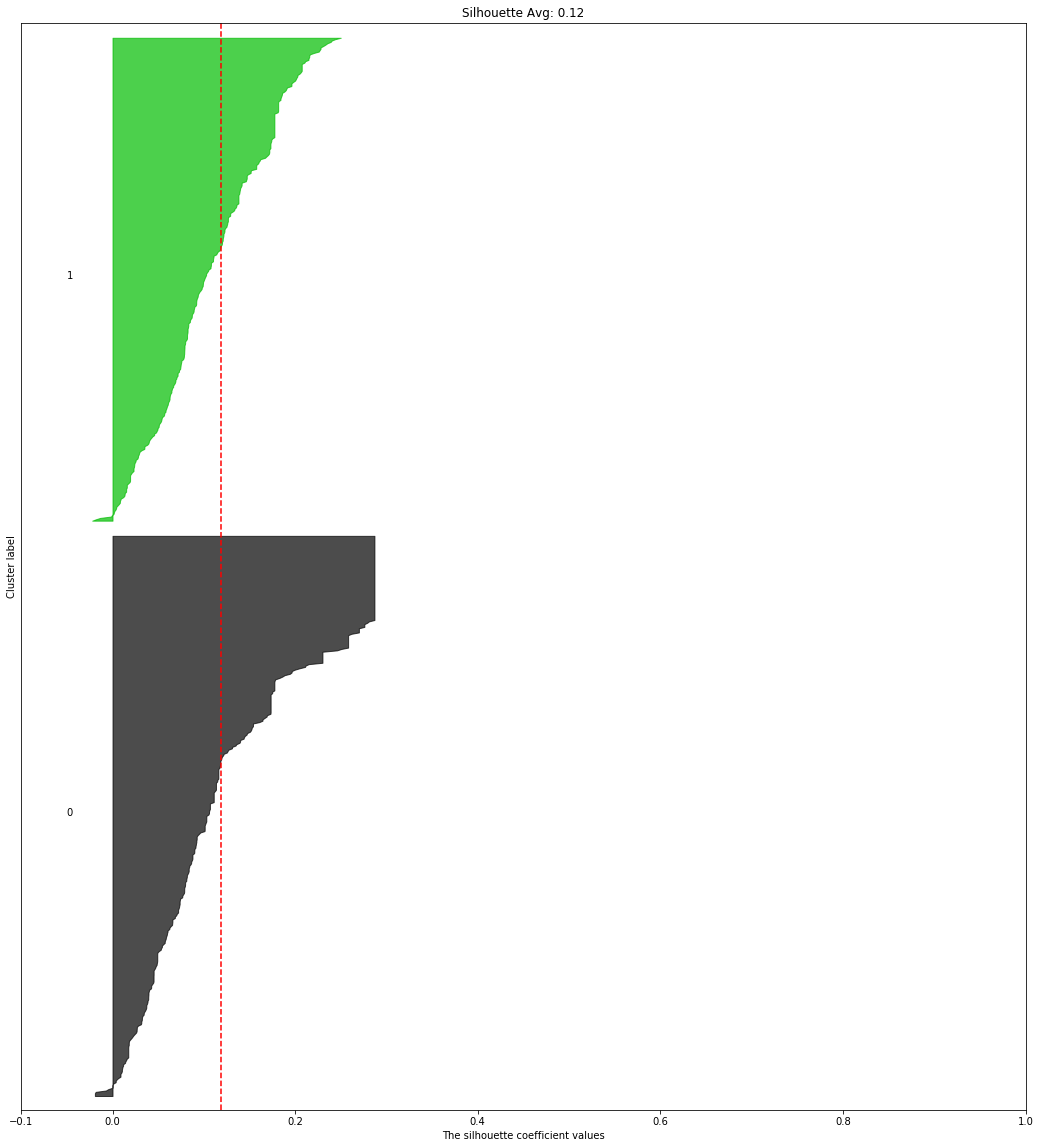

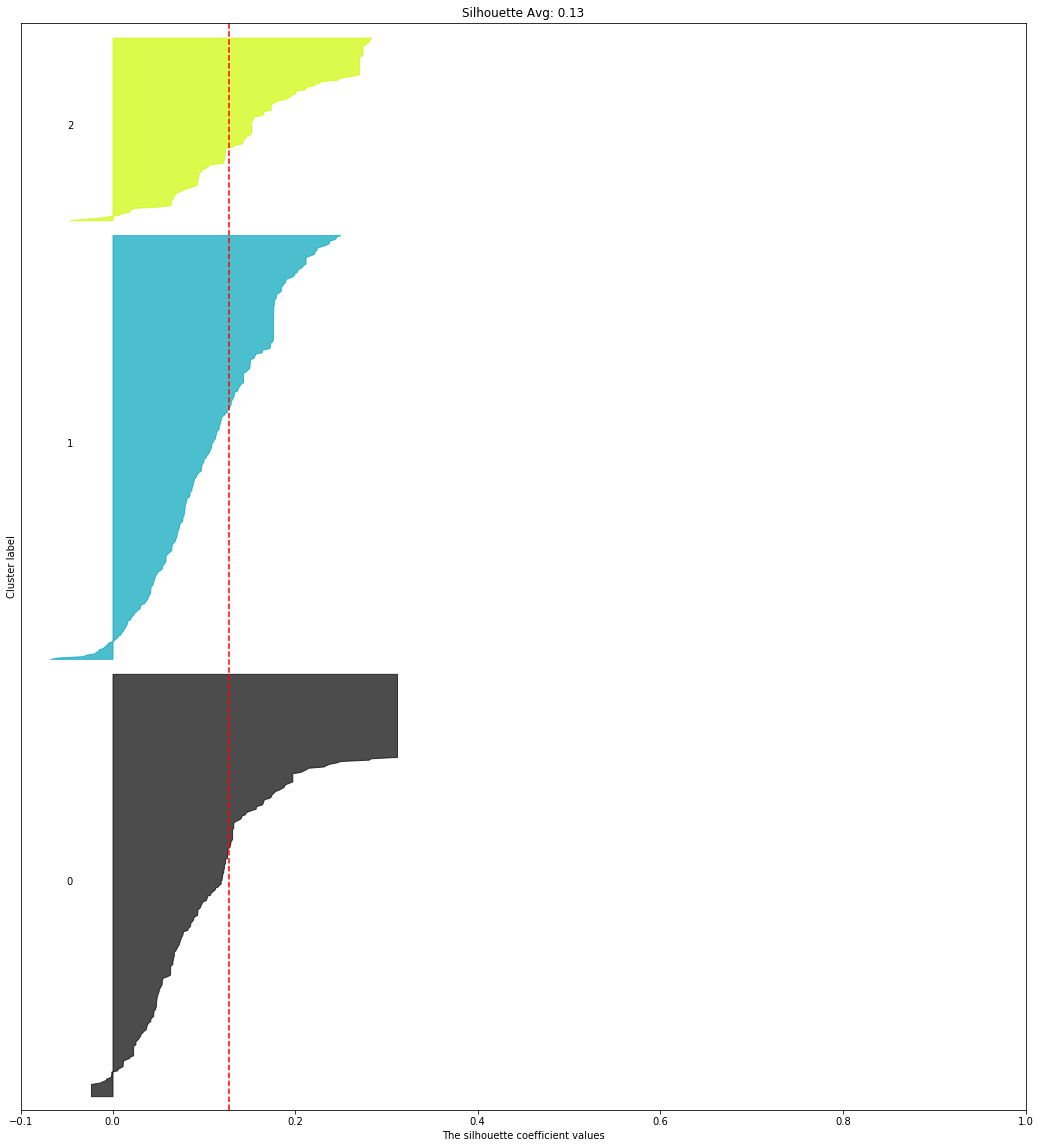

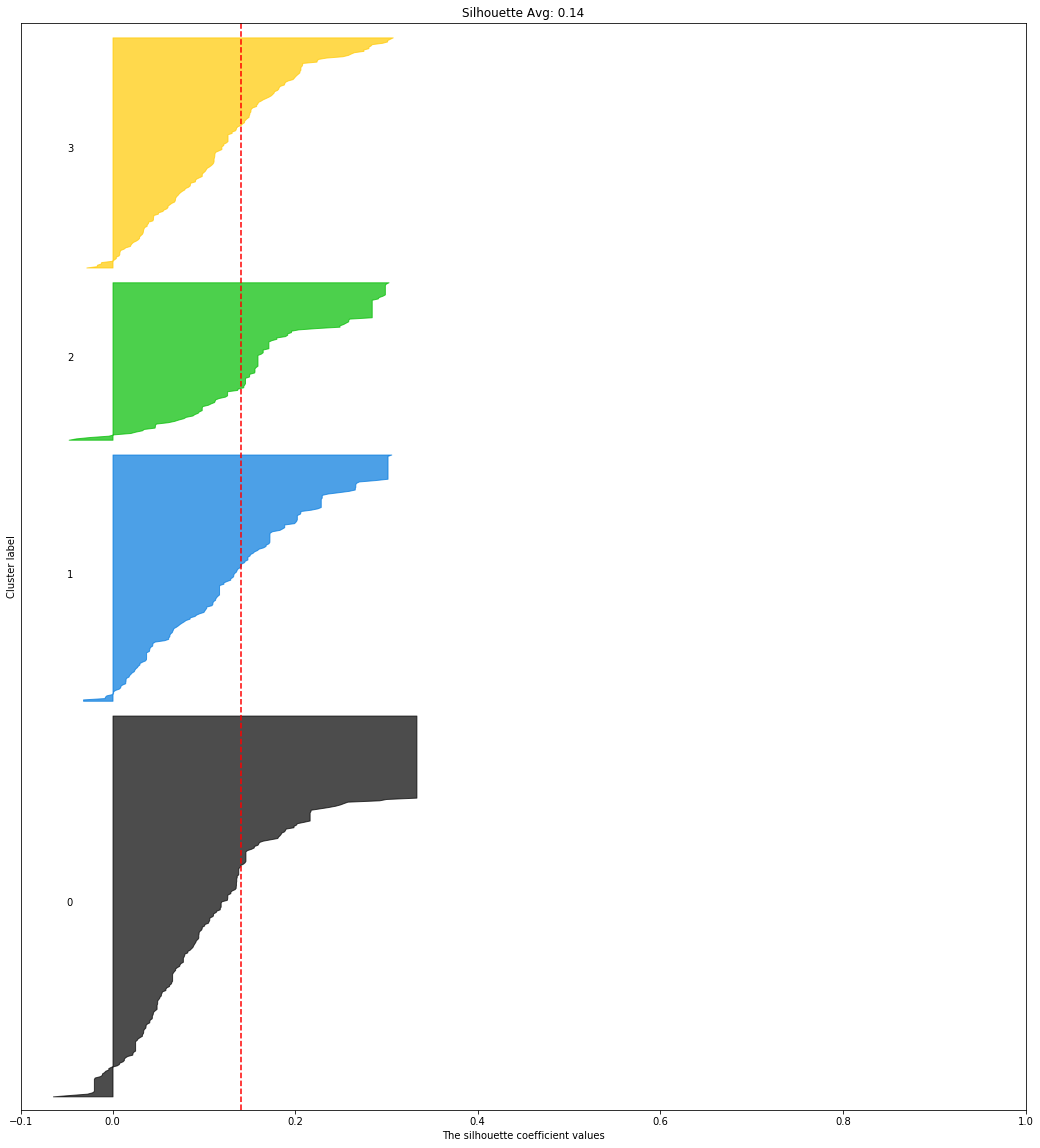

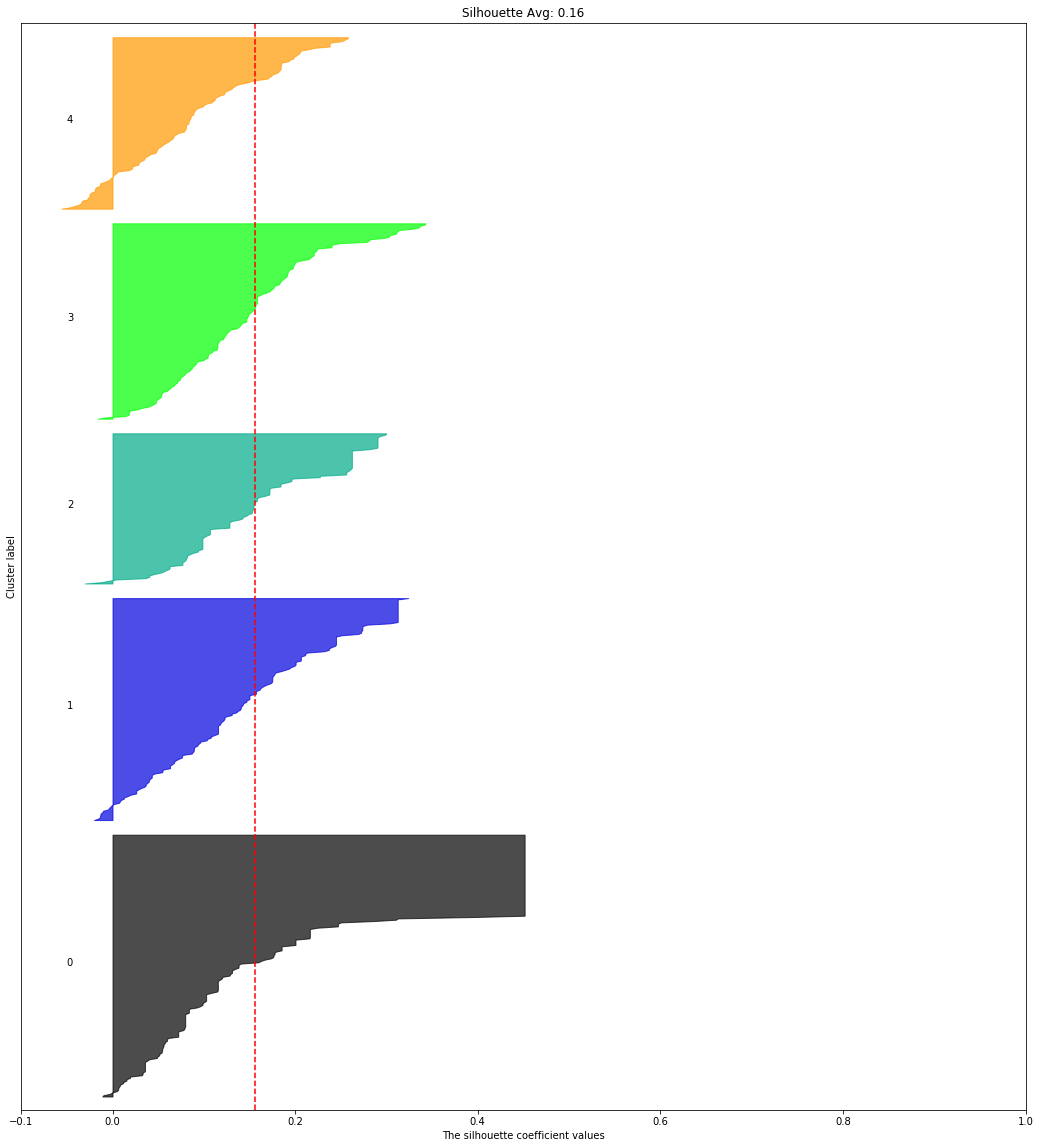

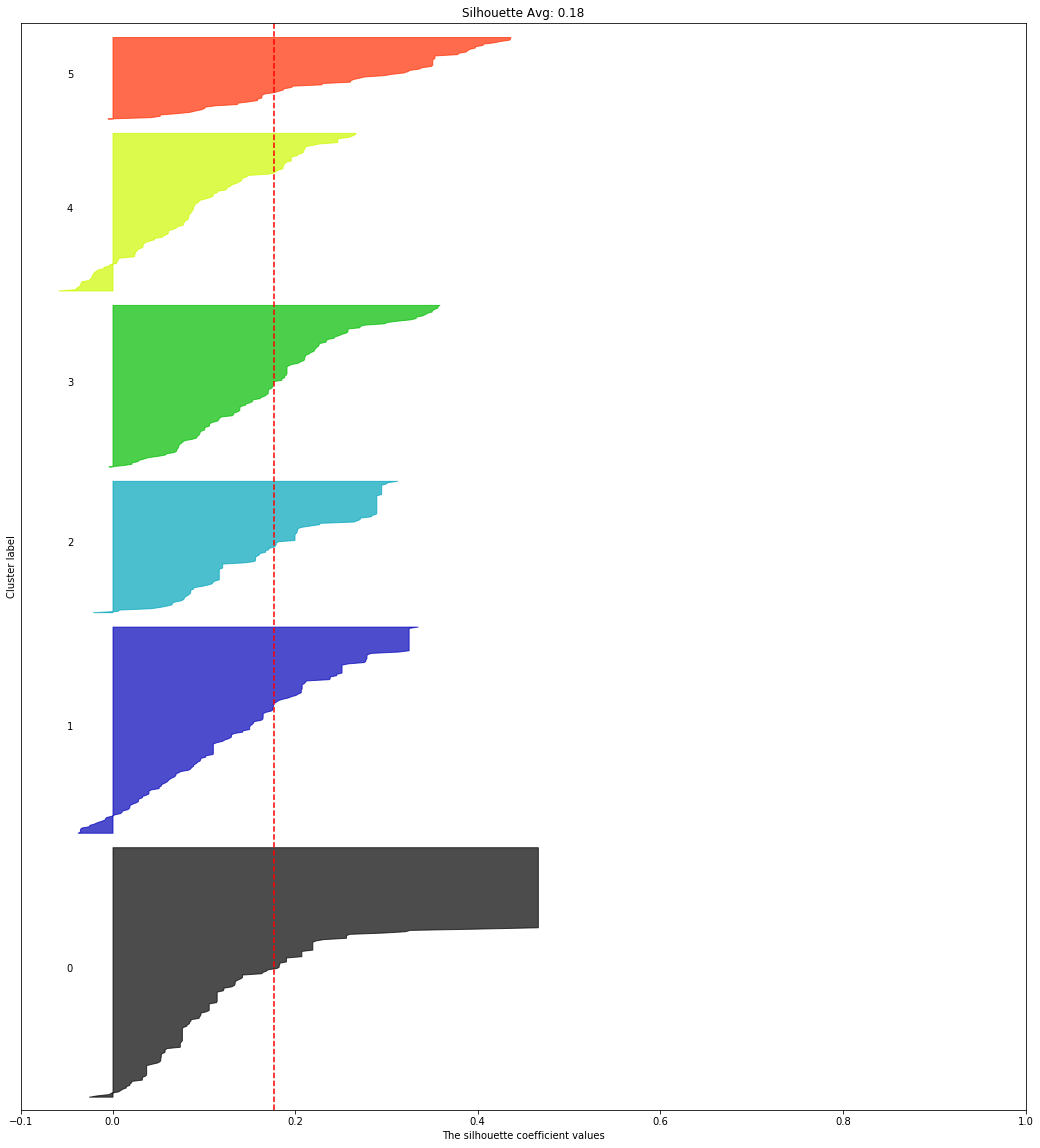

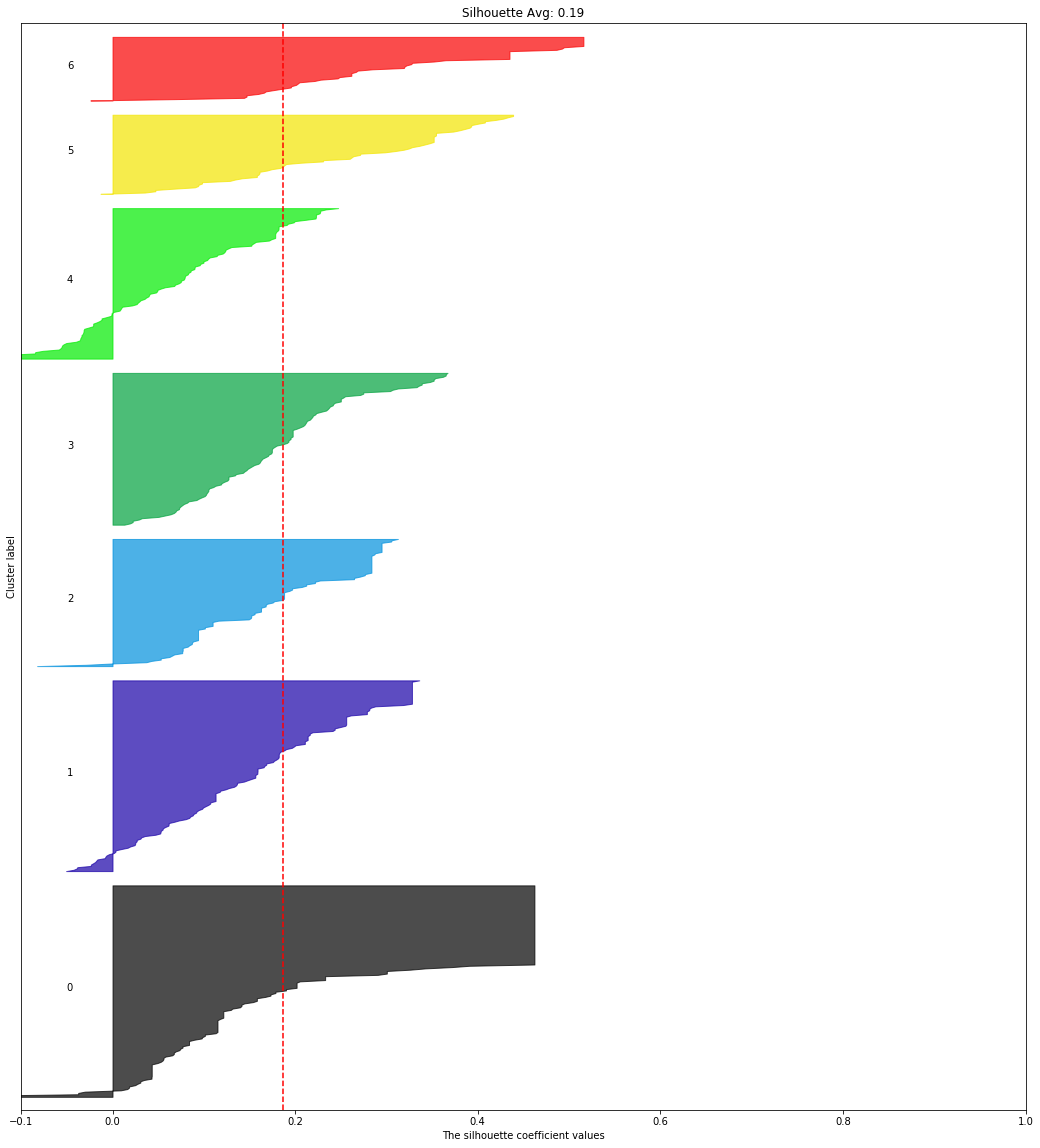

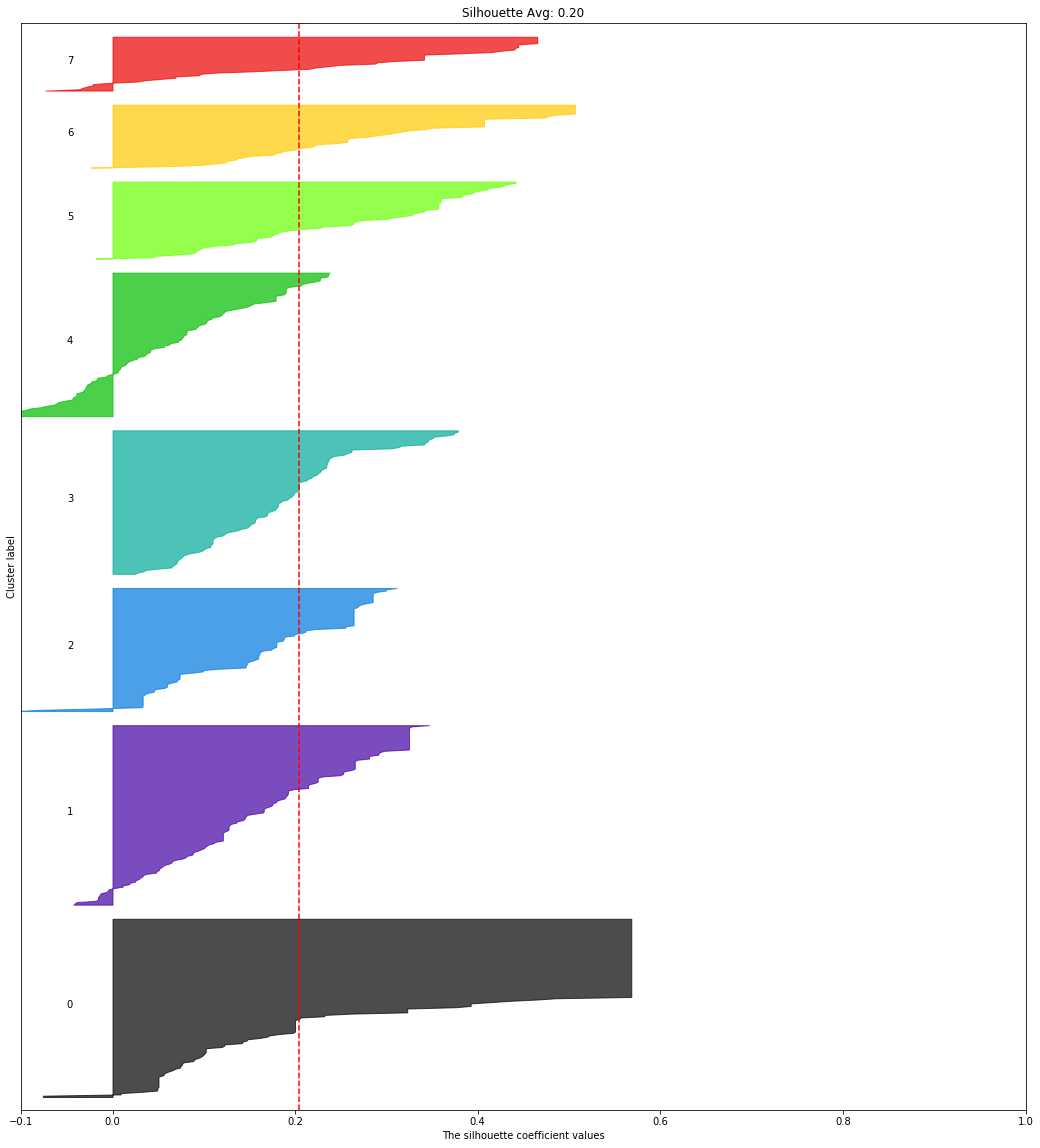

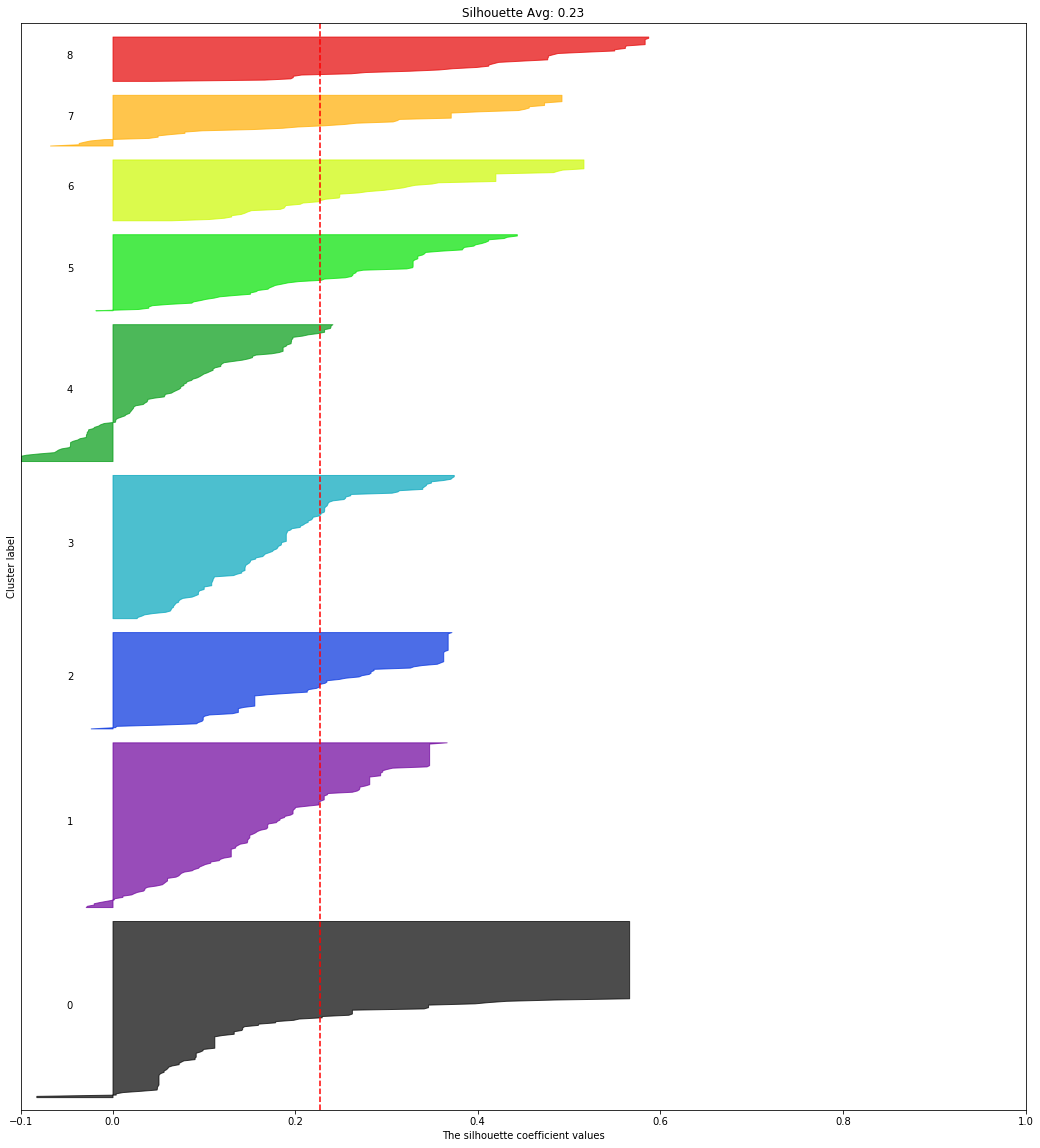

In [33]:
num_topics_sil = range(2, 10)
#num_topics_sil = [50]
# num_topics_sil = [44]
for k in num_topics_sil:
# Compatibility
    X = train_data_features
    n_clusters = k
    cluster_labels = np.argmax(models[k]['document_topic'], axis=1)
    silhouette_avg = models[k]['silhouette']
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 20)
#     fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("Silhouette Avg: %.2f" % silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()